<center><h1>CSCI 4155 Project</h1></center>
<br>
<center><h2>Semantic analysis for amazon review</h2></center>
<br>
<center><h2>Team 13</h2></center>
<br><br>
<center><h4>Name : Yixiao Yuan B00785417</h4><center>
<center><h4>Name : Kessel Zhang B00809478</h4><center>
<center><h4>Name : Tongqi Liu B00764727</h4><center>

#### Attention: You need at least 64GB of memory to run the program, if your computer does not have this much physical memory, please modify the page file size to exceed 64GB

### 1. Data  

#### 1.1  Get the data, Data understanding.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# load csv files.
df_review = pd.read_csv('Reviews.csv')
df_review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
# a concise summary of a DataFrame .
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


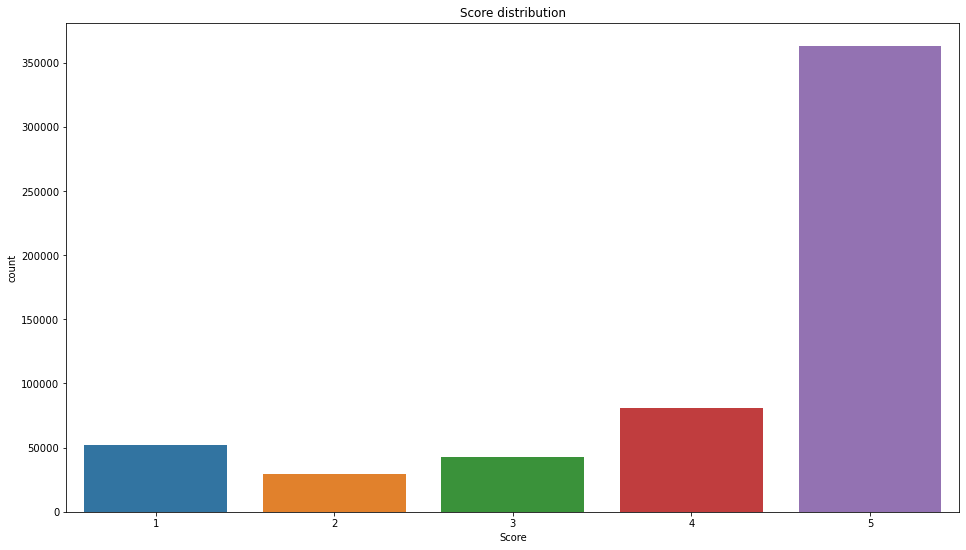

In [3]:
plt.figure(figsize=(16,9))
plt.title('Score distribution')
sns.countplot(data=df_review,x='Score')
plt.show()

#### 1.2.Data preprocessing
+ For sentiment analysis, we will convert label to 0 or 1 (0: Negative Review, 1: Positive Review)
+ Dropping Score=3 as it is neutral value

In [4]:
# convert label to 0 or 1 (0: Negative Review, 1: Positive Review)
df_review.loc[df_review['Score'] <=2, 'Score'] = 0
df_review.loc[df_review['Score'] > 3, 'Score'] = 1

# Dropping Score=3 as it is neutral value
df_review.drop(df_review[df_review['Score']==3].index,inplace=True)

df_data = df_review[['Text','Score']]

del df_review

+ Random sampling 48000 records as training data and test data

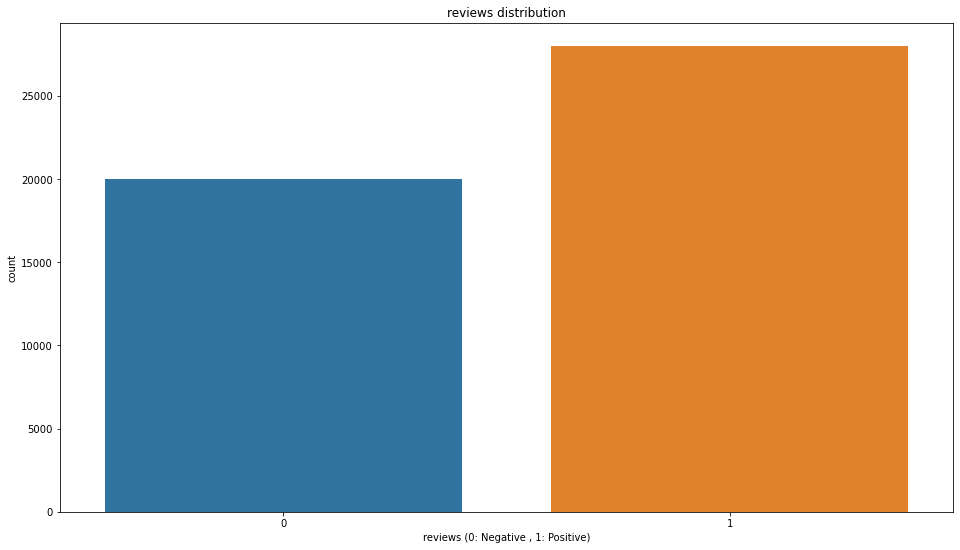

In [5]:
# Random sampling positive reviews and negative reviews data
df_sample_pos = df_data[df_data['Score'] == 1].sample(n=28000, random_state=30) 
df_sample_neg = df_data[df_data['Score'] == 0].sample(n=20000, random_state=30) 
df_sample = df_sample_pos.append(df_sample_neg,ignore_index=True)

del df_data,df_sample_pos,df_sample_neg

from sklearn.utils import shuffle
# shuffle data 
df_sample = shuffle(df_sample)

# reviews distribution
plt.figure(figsize=(16,9))
plt.title('reviews distribution')
ax  = sns.countplot(data=df_sample,x= 'Score')
ax.set_xlabel('reviews (0: Negative , 1: Positive)')
plt.show()

#### 1.3.Text normalization  :

+ a. Tokenization and remove html tag

+ b. Remove stop words, remove numbers and other non-letter characters

+ c. Perform  WordNet Lemmatizer.

+ d. analyze the top most frequent words (Positive or Negative Review) in reviews.

In [6]:
# First run, the necessary datasets/models for specific functions to work.

# import nltk
# nltk.download()

In [7]:
# import BeautifulSoup4 for pulling data out of HTML and XML files.
from bs4 import BeautifulSoup
# Import the word tokenizer from nltk
from nltk.tokenize import word_tokenize
# Import stop word lexicon from nltk
from nltk.corpus import stopwords
# Import the word pos_tag from nltk
from nltk import pos_tag
# import WordNet Lemmatizer from nltk 
from nltk.stem.wordnet import WordNetLemmatizer


# Process the given text, removing HTML tags, stop words, Perform Lemmatizer.
#   Args:
#        text (str): [input text]
#        lemmatize  (bool): [= true, perform  stemming]
#        only_nouns (bool): [= true, using only the nouns]
#    Returns:
#        [type]: text [processed text]
#
def process_text(text: str, lemmatize: bool = False, only_nouns: bool = False):
    # Remove all style, scripts, and HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Tokenize into words, also splitting off some punctuation
    word_tokens = word_tokenize(text)

    # crate a vocabulary of stop words
    stop_words = set(stopwords.words('english'))

    # Remove stop words ,filter out stop word tokens
    filtered_words = [w for w in word_tokens if not w.lower() in stop_words]

    # remove numbers, punctuation marks, individual letters and other non-letter characters
    words = [word.lower() for word in filtered_words if (word.isalpha() and len(word) > 1)]

    # Perform  WordNet Lemmatizer.
    if(lemmatize):
        # instantiate Lemmatizer
        wnl = WordNetLemmatizer()
        # create new sentence with stemmed words
        lemm_words = [wnl.lemmatize(w) for w in words]
        words = lemm_words
        
    # using only the nouns
    if(only_nouns):
        noun_tag = ['NN', 'NNS', 'NNP', 'NNPS']
        word_tag = pos_tag(words)
        nouns_words = [word[0] for word in word_tag if (word[1] in noun_tag)]
        words = nouns_words

    # Join all items in a list into a string and return
    return ' '.join(words)


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Convert a list of text documents to a matrix of token counts and a matrix of TF-IDF features.
#   Args:
#        textlist (str)      : [a list of text documents]
#        min_df   (int)      : [= 1, When building the vocabulary ignore terms that have 
#                                    a document frequency strictly lower than the given threshold.]
#        ngram_range         : [= (1,1) The lower and upper boundary of the range of n-values for different word n-grams 
#                                        or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used.]
#        vector_matrix (bool): [= true, return words_freq, count_matrix, tfidf_matrix] 
#                              [= False, return words_freq]
#    Returns:
#        words_freq (pandas dataframe)   : most common words and number of use
#        count_matrix (pandas dataframe) : a matrix of token counts
#        tfidf_matrix (pandas dataframe) : a matrix of TF-IDF features.
#        count_vectorizer                 : Fitted count vectorizer. 
#        tfidf_vectorizer                 : Fitted Tfidf vectorizer.    
#
def textlist_to_vector(textlist: list, min_df: int = 10, ngram_range: tuple = (1,1) ,vector_matrix:bool=False):
    
    count_vectorizer = CountVectorizer(min_df=min_df, dtype=np.uint8,ngram_range=ngram_range)
    
    # Convert a list of text documents to a matrix of token counts.
    X = count_vectorizer.fit_transform(textlist)
    X_matrix = X.toarray()
    X_sum = X_matrix.sum(axis=0)
    X_names = count_vectorizer.get_feature_names_out()

    # tf_word_number = -1 , all words. 
    # the distribution of the top  most frequent words
    words_freq =  pd.DataFrame(zip(X_names, X_sum),columns=['word','freq'])
    words_freq.sort_values(by=['freq'],ascending=False,inplace=True)
    top_freq_words = words_freq['word'].values.tolist()
    
    if(vector_matrix):
        # convert numpy array to dataframe
        df = pd.DataFrame(data=X_matrix, columns=X_names)
        count_matrix = df[top_freq_words]

        # Convert a list of raw documents to a matrix of TF-IDF features.
        tfidf_vectorizer = TfidfVectorizer(min_df=min_df, dtype=np.float32,ngram_range=ngram_range)
        X = tfidf_vectorizer.fit_transform(textlist)
        X_matrix = X.toarray()
    
        # convert numpy array to dataframe
        df = pd.DataFrame(data=X_matrix, columns=X_names)   
        tfidf_matrix = df[top_freq_words]
        
        return words_freq, count_matrix, tfidf_matrix, count_vectorizer, tfidf_vectorizer
    else:
        return words_freq

# display the top most frequent words in the reviews.
#   Args:
#        words_freq(pd.DataFrame) : [the top most frequent words and count]
#        word_type(str)           : [word type, eg. 'words','nouns']
#    Returns:
#        none
#
def disp_words_freq(words_freq:pd.DataFrame, word_type:str = 'words'):
    # print the top most frequent words in the reviews:
    words_list = words_freq.values.tolist()
    tf_word_number = len(words_list)
    print("the top",tf_word_number,"most frequent",word_type,"in the reviews:")
    i = 0
    for word,freq in words_list:
        print("({0:13s},{1:6d})".format("'"+word+"'",freq),end=" ")
        i+=1
        if(i == 5):
            print("")
            i=0

    # draw the distribution of the top ** most frequent words
    plt.rcParams["figure.figsize"] = [16, 9]
    plt.rcParams["font.size"] = 11
    plt.xticks(rotation=70)
    plt.title("the distribution of the top " + str(tf_word_number) + " most frequent " + word_type + " in the reviews")
    plt.ylabel('frequency')
    plt.xlabel("the top " + str(tf_word_number) + " most frequent " + word_type)
    plt.bar(words_freq['word'], words_freq['freq'])
    # plt.grid(True)
    plt.xlim([-0.5,len(words_freq['word'])-0.5])
    plt.show()
    return


+ the distribution of the top 50 most frequent words (Negative Review) in reviews.

the top 50 most frequent words (Negative Review) in the reviews:
('like'       , 10892) ('taste'      ,  9611) ('product'    ,  9363) ('would'      ,  7327) ('one'        ,  7158) 
('flavor'     ,  6087) ('food'       ,  5800) ('coffee'     ,  5556) ('good'       ,  5256) ('tea'        ,  4365) 
('dog'        ,  4293) ('get'        ,  4140) ('even'       ,  3927) ('bag'        ,  3703) ('buy'        ,  3651) 
('box'        ,  3622) ('time'       ,  3592) ('really'     ,  3430) ('much'       ,  3321) ('amazon'     ,  3280) 
('could'      ,  3033) ('tried'      ,  2946) ('make'       ,  2854) ('first'      ,  2747) ('bought'     ,  2707) 
('love'       ,  2575) ('bad'        ,  2574) ('eat'        ,  2540) ('made'       ,  2521) ('review'     ,  2483) 
('try'        ,  2480) ('better'     ,  2449) ('also'       ,  2399) ('cat'        ,  2380) ('got'        ,  2325) 
('ingredient' ,  2321) ('water'      ,  2309) ('chocolate'  ,  2285) ('thought'    ,  2276) ('way'        ,  2247) 
('know'

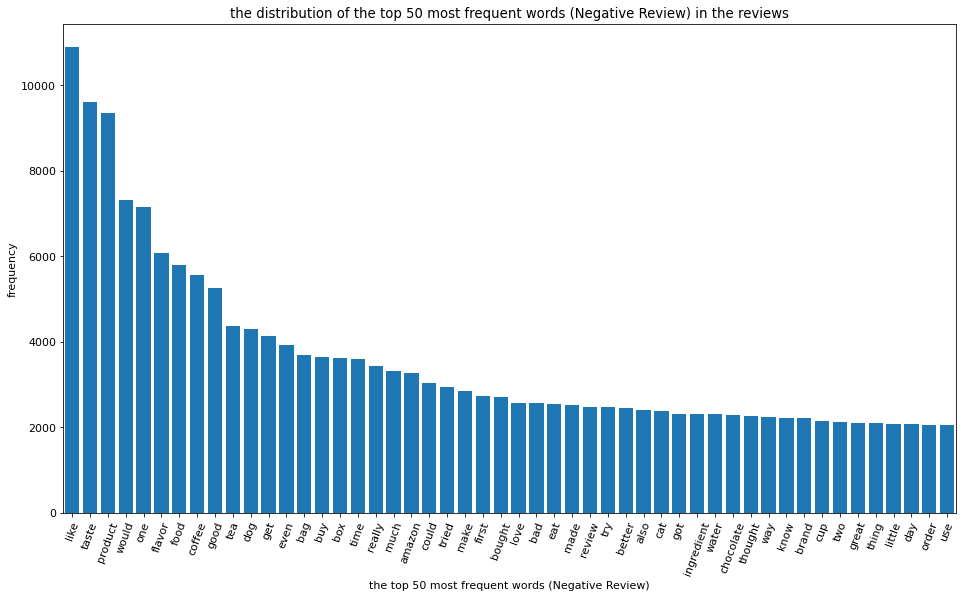

In [8]:
# Negative Review
X_raw_data = np.array(df_sample['Text'][df_sample['Score'] == 0])

# the distribution number of the most frequent words
tf_word_number = 50
# using only the nouns
only_nouns = False

# Removing HTML tags, stop words, perform slemmatize.
X_data=[]
for text in X_raw_data:
    X_data.append(process_text(text=text, only_nouns=only_nouns, lemmatize=True))

# find the top most frequent words and frequency.
neg_words_freq = textlist_to_vector(X_data, min_df=1)

# display the top most frequent words in the reviews.
disp_words_freq(neg_words_freq[:tf_word_number] , word_type='words (Negative Review)')

+ the distribution of the top 50 most frequent words (Positive Review) in reviews.

the top 50 most frequent words (Positive Review) in the reviews:
('like'       , 12264) ('good'       , 10067) ('taste'      ,  9458) ('great'      ,  9448) ('love'       ,  9227) 
('one'        ,  8943) ('flavor'     ,  8821) ('coffee'     ,  7997) ('product'    ,  7780) ('tea'        ,  7574) 
('food'       ,  7364) ('get'        ,  5792) ('would'      ,  5641) ('make'       ,  5558) ('dog'        ,  5248) 
('time'       ,  4946) ('really'     ,  4803) ('much'       ,  4404) ('use'        ,  4333) ('little'     ,  4290) 
('best'       ,  4284) ('also'       ,  4265) ('price'      ,  4096) ('amazon'     ,  4046) ('find'       ,  3984) 
('bag'        ,  3864) ('tried'      ,  3759) ('buy'        ,  3496) ('well'       ,  3454) ('day'        ,  3400) 
('store'      ,  3398) ('treat'      ,  3356) ('even'       ,  3328) ('eat'        ,  3327) ('better'     ,  3280) 
('try'        ,  3192) ('year'       ,  3146) ('cat'        ,  3124) ('cup'        ,  3106) ('chocolate'  ,  2989) 
('drink

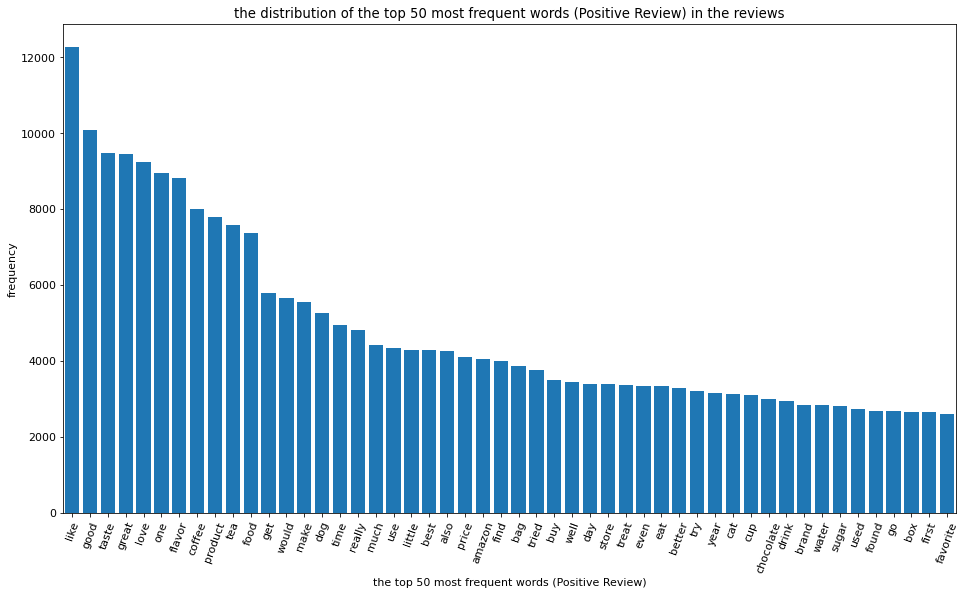

In [9]:
# Positive Review
X_raw_data = np.array(df_sample['Text'][df_sample['Score'] == 1])

# the distribution number of the most frequent words
tf_word_number = 50
# using only the nouns
only_nouns = False

# Removing HTML tags, stop words, perform slemmatize.
X_data=[]
for text in X_raw_data:
    X_data.append(process_text(text=text, only_nouns=only_nouns, lemmatize=True))

# find the top most frequent words and frequency.
pos_words_freq = textlist_to_vector(X_data, min_df=1)

# display the top most frequent words in the reviews.
disp_words_freq(pos_words_freq[:tf_word_number] , word_type='words (Positive Review)')

+ the distribution of the top 50 most frequent words in reviews.

the top 50 most frequent words in the reviews:
('like'       , 23156) ('taste'      , 19069) ('product'    , 17143) ('one'        , 16101) ('good'       , 15323) 
('flavor'     , 14908) ('coffee'     , 13553) ('food'       , 13164) ('would'      , 12968) ('tea'        , 11939) 
('love'       , 11802) ('great'      , 11549) ('get'        ,  9932) ('dog'        ,  9541) ('time'       ,  8538) 
('make'       ,  8412) ('really'     ,  8233) ('much'       ,  7725) ('bag'        ,  7567) ('amazon'     ,  7326) 
('even'       ,  7255) ('buy'        ,  7147) ('tried'      ,  6705) ('also'       ,  6664) ('use'        ,  6388) 
('little'     ,  6378) ('box'        ,  6287) ('price'      ,  6146) ('eat'        ,  5867) ('find'       ,  5804) 
('better'     ,  5729) ('try'        ,  5672) ('could'      ,  5513) ('cat'        ,  5504) ('day'        ,  5485) 
('best'       ,  5417) ('first'      ,  5403) ('chocolate'  ,  5274) ('cup'        ,  5253) ('well'       ,  5196) 
('water'      ,  5134) ('

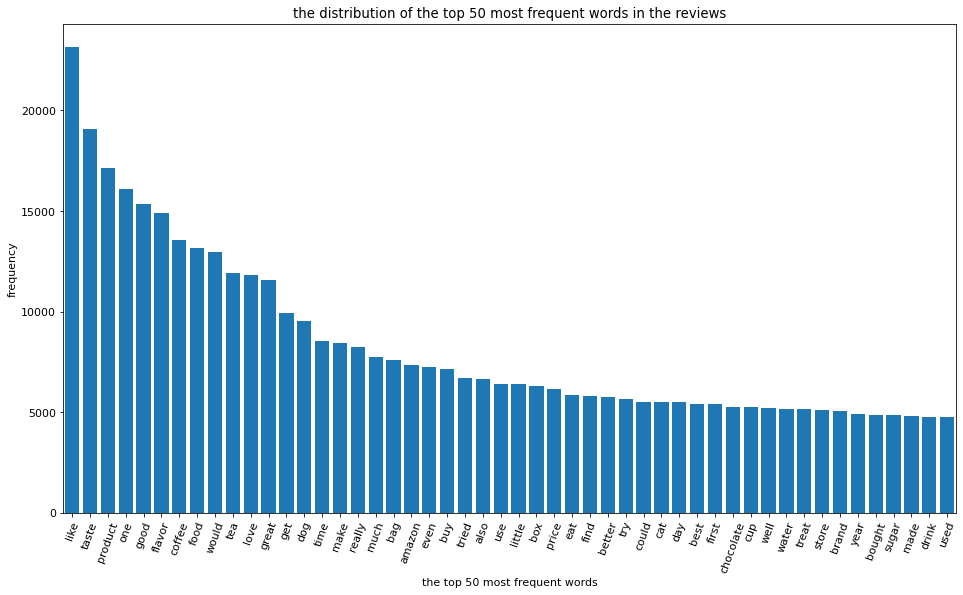

In [10]:
# all sampling data
X_raw_data = np.array(df_sample['Text'])

# the distribution number of the most frequent words
tf_word_number = 50
# using only the nouns
only_nouns = False

# Removing HTML tags, stop words, perform slemmatize.
X_data=[]
for text in X_raw_data:
    X_data.append(process_text(text=text, only_nouns=only_nouns, lemmatize=True))

# find the top most frequent words and frequency.
words_freq = textlist_to_vector(X_data, min_df=1)

# display the top most frequent words in the reviews.
disp_words_freq(words_freq[:tf_word_number])

+ the distribution of the top 50 most frequent nouns in reviews.

the top 50 most frequent nouns in the reviews:
('taste'      , 17346) ('product'    , 17143) ('flavor'     , 13781) ('food'       , 13164) ('coffee'     , 13089) 
('tea'        , 10390) ('time'       ,  8538) ('dog'        ,  8157) ('bag'        ,  6329) ('price'      ,  6146) 
('box'        ,  5491) ('day'        ,  5485) ('water'      ,  5134) ('brand'      ,  5057) ('year'       ,  4907) 
('cat'        ,  4881) ('chocolate'  ,  4837) ('store'      ,  4777) ('love'       ,  4743) ('use'        ,  4661) 
('way'        ,  4627) ('treat'      ,  4622) ('thing'      ,  4469) ('cup'        ,  4339) ('sugar'      ,  4280) 
('order'      ,  4184) ('amazon'     ,  3902) ('chip'       ,  3687) ('something'  ,  3623) ('eat'        ,  3575) 
('try'        ,  3520) ('review'     ,  3408) ('bar'        ,  3336) ('lot'        ,  3048) ('ingredient' ,  2991) 
('package'    ,  2979) ('work'       ,  2890) ('quality'    ,  2859) ('pack'       ,  2847) ('bit'        ,  2783) 
('month'      ,  2746) ('

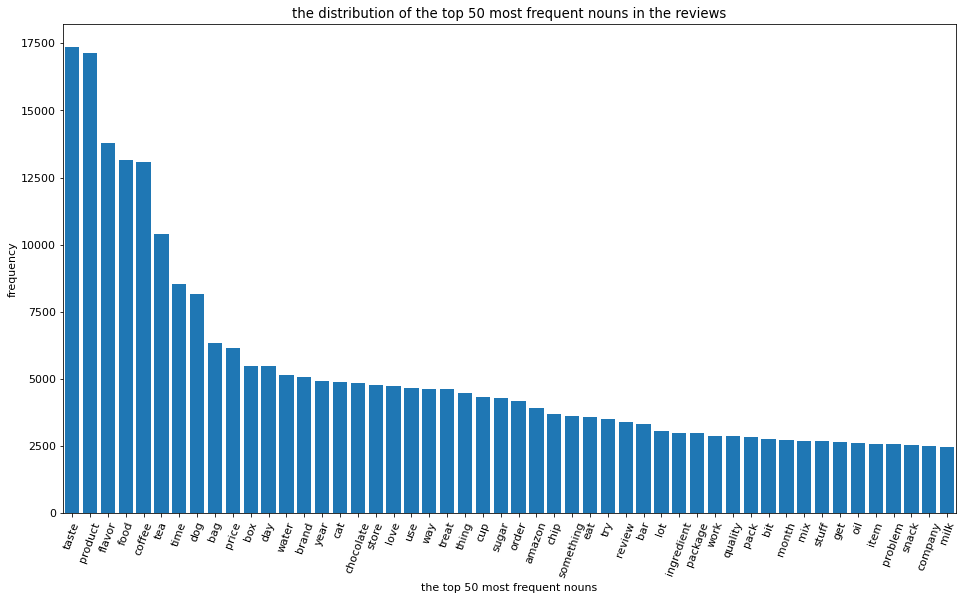

In [11]:
# all sampling data
X_raw_data = np.array(df_sample['Text'])

# the distribution number of the most frequent words
tf_word_number = 50
# using only the nouns
only_nouns = True

# Removing HTML tags, stop words, perform lemmatize.
X_nouns_data=[]
for text in X_raw_data:
    X_nouns_data.append(process_text(text=text, only_nouns=only_nouns, lemmatize=True))


# find the top most frequent words and frequency.
nouns_freq = textlist_to_vector(X_nouns_data, min_df=1)

# display the top most frequent words in the reviews.
disp_words_freq(nouns_freq[:tf_word_number],word_type='nouns')

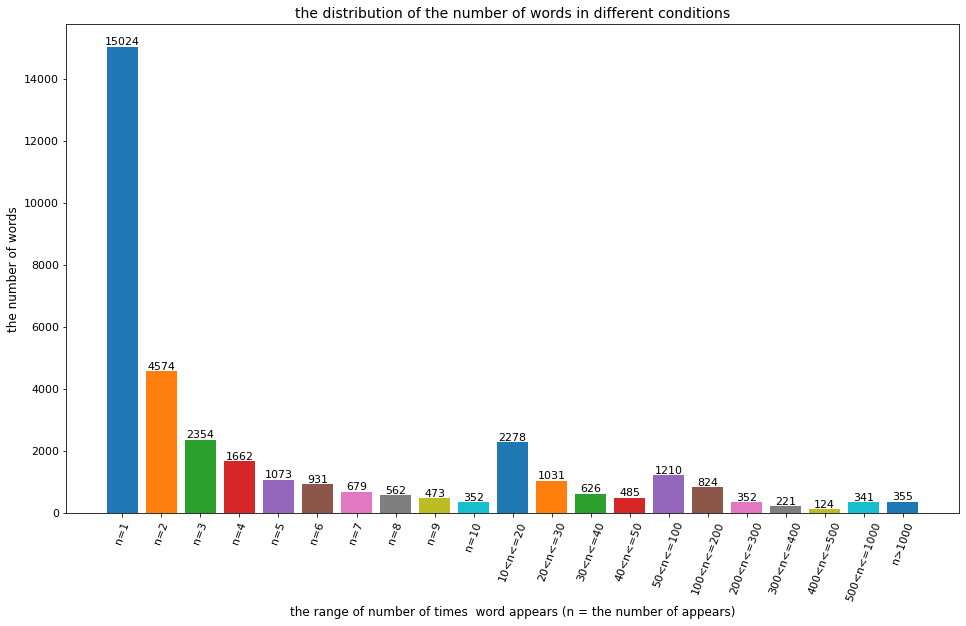

In [12]:
# the range of number of times  word appears
words_num =[1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300,400,500,1000]
words_range = []
words_count = []

start = 0
for num in words_num:
    words_freq['freq']
    words_count.append(words_freq[(words_freq['freq'] > start) & (words_freq['freq'] <= num)]['freq'].count())
    if(num - start > 1):
        words_range.append('{:d}<n<={:d}'.format(start,num))
    else:
        words_range.append('n={:d}'.format(num))
        
    start = num

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

words_count.append(words_freq[words_freq['freq'] > start]['freq'].count())
words_range.append('n>{:d}'.format(start))
    
# draw the distribution of the words
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["font.size"] = 11
plt.xticks(rotation=70)
plt.title("the distribution of the number of words in different conditions",fontsize=14)
plt.ylabel('the number of words',fontsize=12)
plt.xlabel('the range of number of times  word appears (n = the number of appears)',fontsize=12)
bar = plt.bar(words_range, words_count,color=colors)
plt.bar_label(bar)
plt.show()



#### 1.4. Convert the data to a matrix of token counts and a matrix of TF-IDF features,split training data and test data.

In [13]:
# all sampling data
# X_raw_data = np.array(df_sample['Text'])
y_data = np.array(df_sample['Score'])

del X_raw_data
del pos_words_freq,neg_words_freq

In [14]:
from sklearn.model_selection import train_test_split

# Convert the data to a matrix of token counts and a matrix of TF-IDF features.
words_freq, count_matrix, tfidf_matrix, count_vectorizer, tfidf_vectorizer = textlist_to_vector(X_data, vector_matrix=True)

# Split a matrix of token counts into random train and test subsets
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(count_matrix, y_data, test_size=0.2, random_state=30)
del count_matrix

# Split  a matrix of TF-IDF features into random train and test subsets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, y_data, test_size=0.2, random_state=30)
del tfidf_matrix

# the matrix of token counts
pd.DataFrame(np.array(X_train_count),columns=np.array(words_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,examine,multitude,conditioned,collected,mt,comfortably,comparatively,compatible,moisten,colder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38397,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38398,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# the matrix of TF-IDF features
pd.DataFrame(np.array(X_train_tfidf),columns=np.array(words_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,examine,multitude,conditioned,collected,mt,comfortably,comparatively,compatible,moisten,colder
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.143898,0.0,0.0,0.000000,0.156258,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.132613,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.140802,0.000000,0.000000,0.000000,0.0,0.0,0.094335,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.306003,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.000000,0.000000,0.000000,0.079306,0.000000,0.0,0.0,0.000000,0.085045,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38396,0.048207,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38397,0.000000,0.000000,0.155086,0.000000,0.076334,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38398,0.000000,0.000000,0.000000,0.000000,0.046898,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Convert the data to a matrix of token counts and a matrix of TF-IDF features.
nouns_freq, nouns_count_matrix, nouns_tfidf_matrix, nouns_count_vectorizer, nouns_tfidf_vectorizer = textlist_to_vector(X_nouns_data, vector_matrix=True)

# Split a matrix of token counts with only nouns into random train and test subsets
X_train_nouns_count, X_test_nouns_count, y_train_nouns_count, y_test_nouns_count = train_test_split(
    nouns_count_matrix, y_data, test_size=0.2, random_state=30)
del nouns_count_matrix

# Split  a matrix  of TF-IDF features with only nouns into random train and test subsets
X_train_nouns_tfidf, X_test_nouns_tfidf, y_train_nouns_tfidf, y_test_nouns_tfidf = train_test_split(
    nouns_tfidf_matrix, y_data, test_size=0.2, random_state=30)
del nouns_tfidf_matrix

# the matrix of token counts (nouns)
pd.DataFrame(np.array(X_train_nouns_count), columns=np.array(nouns_freq['word']))

,taste,product,flavor,food,coffee,tea,time,dog,bag,price,...,ew,shorthair,staleness,astringent,athlete,airline,diglycerides,paprika,tj,oops
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38396,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38397,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# the matrix of TF-IDF features (nouns)
pd.DataFrame(np.array(X_train_nouns_tfidf), columns=np.array(nouns_freq['word']))

,taste,product,flavor,food,coffee,tea,time,dog,bag,price,...,ew,shorthair,staleness,astringent,athlete,airline,diglycerides,paprika,tj,oops
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.231743,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.199941,0.000000,0.0,0.130376,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.412401,0.0,0.0,0.000000,0.159115,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38396,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.084643,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38397,0.000000,0.209205,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38398,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Convert the data to a matrix of token counts and a matrix of TF-IDF features.
ngram2_freq, count_ngram2_matrix, tfidf_ngram2_matrix, count_ngram2_vectorizer, tfidf_ngram2_vectorizer = textlist_to_vector(X_data, ngram_range=(1,2), vector_matrix=True)

# Split a matrix of token counts into random train and test subsets
X_train_ngram2_count, X_test_ngram2_count, y_train_ngram2_count, y_test_ngram2_count = train_test_split(count_ngram2_matrix, y_data, test_size=0.2, random_state=30)
del count_ngram2_matrix

# Split  a matrix of TF-IDF features into random train and test subsets
X_train_ngram2_tfidf, X_test_ngram2_tfidf, y_train_ngram2_tfidf, y_test_ngram2_tfidf = train_test_split(tfidf_ngram2_matrix, y_data, test_size=0.2, random_state=30)
del tfidf_ngram2_matrix

# the matrix of token counts
pd.DataFrame(np.array(X_train_ngram2_count), columns=np.array(ngram2_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,however every,chocolate filling,tier,however husband,however looking,tight container,however much,however read,time adding,cheap profit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38397,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38398,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# the matrix of TF-IDF features (ngram2)
pd.DataFrame(np.array(X_train_ngram2_tfidf), columns=np.array(ngram2_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,however every,chocolate filling,tier,however husband,however looking,tight container,however much,however read,time adding,cheap profit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.092848,0.0,0.0,0.000000,0.100824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.105369,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.101042,0.000000,0.000000,0.000000,0.0,0.0,0.067697,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.234471,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.000000,0.000000,0.000000,0.059238,0.000000,0.0,0.0,0.000000,0.063524,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38396,0.038235,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38397,0.000000,0.000000,0.112935,0.000000,0.055587,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38398,0.000000,0.000000,0.000000,0.000000,0.044732,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.model_selection import train_test_split
# y_data = np.array(df_sample['Score'])

# Convert the data to a matrix of token counts and a matrix of TF-IDF features.
ngram3_freq, count_ngram3_matrix, tfidf_ngram3_matrix, count_ngram3_vectorizer, tfidf_ngram3_vectorizer = textlist_to_vector(X_data, ngram_range=(1,3), vector_matrix=True)

# Split a matrix of token counts into random train and test subsets
X_train_ngram3_count, X_test_ngram3_count, y_train_ngram3_count, y_test_ngram3_count = train_test_split(count_ngram3_matrix, y_data, test_size=0.2, random_state=30)
del count_ngram3_matrix

# Split  a matrix of TF-IDF features into random train and test subsets
X_train_ngram3_tfidf, X_test_ngram3_tfidf, y_train_ngram3_tfidf, y_test_ngram3_tfidf = train_test_split(tfidf_ngram3_matrix, y_data, test_size=0.2, random_state=30)
del tfidf_ngram3_matrix

# the matrix of token counts
pd.DataFrame(np.array(X_train_ngram3_count), columns=np.array(ngram3_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,ground whole,teeth one,ground bottom cup,gross know,gross even,tell everyone,tell good quite,tell honesty,tell honesty product,like weak coffee
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38397,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38398,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# the matrix of TF-IDF features (ngram3)
pd.DataFrame(np.array(X_train_ngram3_tfidf), columns=np.array(ngram3_freq['word']))

,like,taste,product,one,good,flavor,coffee,food,would,tea,...,ground whole,teeth one,ground bottom cup,gross know,gross even,tell everyone,tell good quite,tell honesty,tell honesty product,like weak coffee
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.092848,0.0,0.0,0.000000,0.100824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.105369,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.099263,0.000000,0.000000,0.000000,0.0,0.0,0.066505,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.234471,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.000000,0.000000,0.000000,0.059238,0.000000,0.0,0.0,0.000000,0.063524,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38396,0.038235,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38397,0.000000,0.000000,0.112935,0.000000,0.055587,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38398,0.000000,0.000000,0.000000,0.000000,0.044732,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Calculate the memory usage of the training dataset and the test dataset

feature = ['Counts (all words)', 'TF-IDF (all words)', 'Counts (only nouns)', 'TF-IDF (only nouns)',
            'Counts (N-gram n=2)', 'TF-IDF(N-gram n=2)', 'Counts (N-gram n=3)', 'TF-IDF (N-gram n=3)']
var_type = ['np.uint16','np.float32','np.uint16','np.float32','np.uint16','np.float32','np.uint16','np.float32']
var_size = [2,4,2,4,2,4,2,4]


matrix_row = [X_train_count.shape[0] + X_test_count.shape[0], 
            X_train_tfidf.shape[0] + X_test_tfidf.shape[0], 
            X_train_nouns_count.shape[0] + X_test_nouns_count.shape[0],  
            X_train_nouns_tfidf.shape[0] + X_test_nouns_tfidf.shape[0],
            X_train_ngram2_count.shape[0] + X_test_ngram2_count.shape[0], 
            X_train_ngram2_tfidf.shape[0] + X_test_ngram2_tfidf.shape[0], 
            X_train_ngram3_count.shape[0] + X_test_ngram3_count.shape[0], 
            X_train_ngram3_tfidf.shape[0] + X_test_ngram3_tfidf.shape[0]]

matrix_col = [X_train_count.shape[1], X_train_tfidf.shape[1], X_train_nouns_count.shape[1], X_train_nouns_tfidf.shape[1],
            X_train_ngram2_count.shape[1], X_train_ngram2_tfidf.shape[1], X_train_ngram3_count.shape[1], X_train_ngram3_tfidf.shape[1]]

df_matrix = pd.DataFrame(data=feature,columns=['feature matrix'])
df_matrix['matrix rows'] = matrix_row
df_matrix['matrix columns'] = matrix_col
df_matrix['dtype'] = var_type
df_matrix['dtype size(byte)'] = var_size
df_matrix['Memory usage (GB)'] = np.round((df_matrix['matrix rows']*df_matrix['matrix columns']*df_matrix['dtype size(byte)']/1073741824),2)
df_matrix

,feature matrix,matrix rows,matrix columns,dtype,dtype size(byte),Memory usage (GB)
0,Counts (all words),48000,7737,np.uint16,2,0.69
1,TF-IDF (all words),48000,7737,np.float32,4,1.38
2,Counts (only nouns),48000,4339,np.uint16,2,0.39
3,TF-IDF (only nouns),48000,4339,np.float32,4,0.78
4,Counts (N-gram n=2),48000,28918,np.uint16,2,2.59
5,TF-IDF(N-gram n=2),48000,28918,np.float32,4,5.17
6,Counts (N-gram n=3),48000,31541,np.uint16,2,2.82
7,TF-IDF (N-gram n=3),48000,31541,np.float32,4,5.64


In [23]:
# model_attr used to store the model's AUC score and accuracy
model_attr = []

### 2. Artificial Neural Network Model

#### 2.1. Building the Artificial Neural Network

+ Initializing the ANN, find best epoche and batch_size.

In [24]:
import tensorflow as tf
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# select the top 100 most frequent words
tf_word_number = 100
tf_word_list = np.array(words_freq['word'])[:tf_word_number]

# a matrix of token counts as training and test data set
x_train = np.array(X_train_count[tf_word_list]).astype(int)
y_train = np.array(y_train_count)
x_test = np.array(X_test_count[tf_word_list]).astype(int)
y_test = np.array(y_test_count)

# Function to create ann model
def create_ann():
    ann = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    ann.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
    return ann


# Callback for compute auc score
class Calc_AUC_Callback(tf.keras.callbacks.Callback):

    def __init__(self, x_train, y_train, x_test, y_test):
        super().__init__()
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test  = x_test
        self.__y_test  = y_test
        self.__auc_score = []
    
    # compute auc score
    def on_epoch_end(self, epoch, logs=None):
        # compute train auc score
        y_pred = self.model.predict(self.__x_train)
        auc_train = roc_auc_score(self.__y_train,y_pred)
        # compute test  auc score
        y_pred = self.model.predict(self.__x_test)
        auc_test = roc_auc_score(self.__y_test,y_pred)
        # print auc score
        print(' - train auc: {0:.4f} - test auc: {1:.4f}'.format(auc_train,auc_test))
        self.__auc_score.append([epoch+1,auc_train,auc_test])
    
    # get auc score
    def get_auc_score(self):
        return self.__auc_score
        
# define the grid search parameters
parameters = {'epochs': 40, 'batch_size': [32,64,96,128,192,256,384,512,768]}

# search over specified parameter values for an estimator.
auc_score_list = []
for size in parameters['batch_size']:
    # 
    tf.keras.backend.clear_session()
    # create ann model
    ann_model = create_ann()
    # create calc AUC callback
    calc_auc = Calc_AUC_Callback( x_train, y_train, x_test, y_test)
    # train model
    ann_model.fit(x_train,y_train,batch_size =size, epochs=parameters['epochs'], callbacks=[calc_auc])
    # save auc score
    auc_score_list.append(calc_auc.get_auc_score())

Epoch 1/40
1200/1200 [==============================] - 3s 2ms/step - loss: 0.5840 - accuracy: 0.6941
Epoch 2/40
1200/1200 [==============================] - 3s 2ms/step - loss: 0.5255 - accuracy: 0.7426
Epoch 3/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.5108 - accuracy: 0.7515
Epoch 4/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.5018 - accuracy: 0.7548
Epoch 5/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4959 - accuracy: 0.7600
Epoch 6/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4901 - accuracy: 0.7632
Epoch 7/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4858 - accuracy: 0.7669
Epoch 8/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4818 - accuracy: 0.7690
Epoch 9/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4790 - accuracy: 0.7711
Epoch 10/40
1200/1200 [==============================] - 2s 2ms/step - loss: 0.474

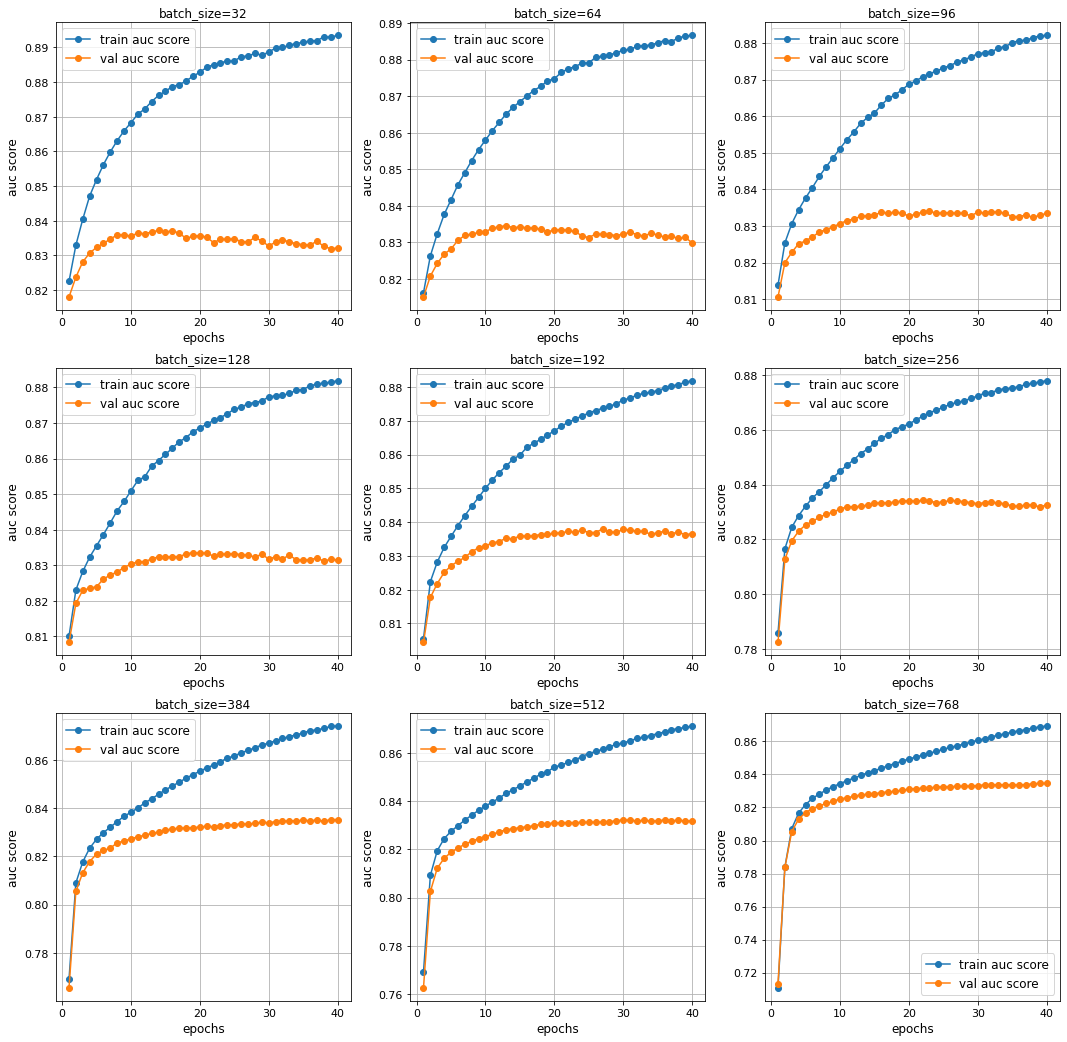

In [25]:
# Plot auc_score  of different batch_size and epochs
row_num = round(len(auc_score_list)/3 + 0.49)
fig,ax = plt.subplots(row_num,3,figsize=(18,6*row_num))

i = 0
for auc_score in auc_score_list:
    auc_labels = ['epochs','train auc score','val auc score']

    df_auc = pd.DataFrame(auc_score,columns=auc_labels)

    # Plot out the validation auc versus the training auc
    x = df_auc['epochs']
    axes = ax[int(i/3),int(i%3)]
    axes.plot(x, df_auc['train auc score'], marker='o', label='train auc score',)
    axes.plot(x, df_auc['val auc score'],   marker='o', label='val auc score')
    axes.set_title('batch_size=' + str(parameters['batch_size'][i]),fontsize=12)
    axes.set_xlabel('epochs',fontsize=12)
    axes.set_ylabel('auc score',fontsize=12)
    axes.legend(fontsize=12)
    axes.grid()

    i += 1

In [26]:
# find best parameters
i = 0
max_auc = 0
best_batch_size,best_epochs = 0,0
for auc_score in auc_score_list:
    auc_labels = ['epochs','train auc score','val auc score']
    df_auc = pd.DataFrame(auc_score,columns=auc_labels)
    
    best_auc = np.max(df_auc['val auc score'])
    epochs = np.argmax(df_auc['val auc score'])+1
    batch_size = parameters['batch_size'][i]
    if(best_auc > max_auc):
        max_auc = best_auc
        best_batch_size = batch_size
        best_epochs = epochs
    i += 1
print('best parameters: epochs = {0},batch_size = {1}'.format(best_epochs,best_batch_size))

best parameters: epochs = 27,batch_size = 192


#### 2.2. Compare the auc score of different feature matrix.
  
  1. the matrix of token counts (all words)
  2. the matrix of TF-IDF features (all words)
  3. the matrix of token counts (only nouns)
  4. the matrix of TF-IDF features (only nouns)
  5. the matrix of token counts (N-gram n=2)
  6. the matrix of TF-IDF features (N-gram n=2)
  7. the matrix of token counts (N-gram n=3)
  8. the matrix of TF-IDF features (N-gram n=3)

<Figure size 1152x648 with 0 Axes>

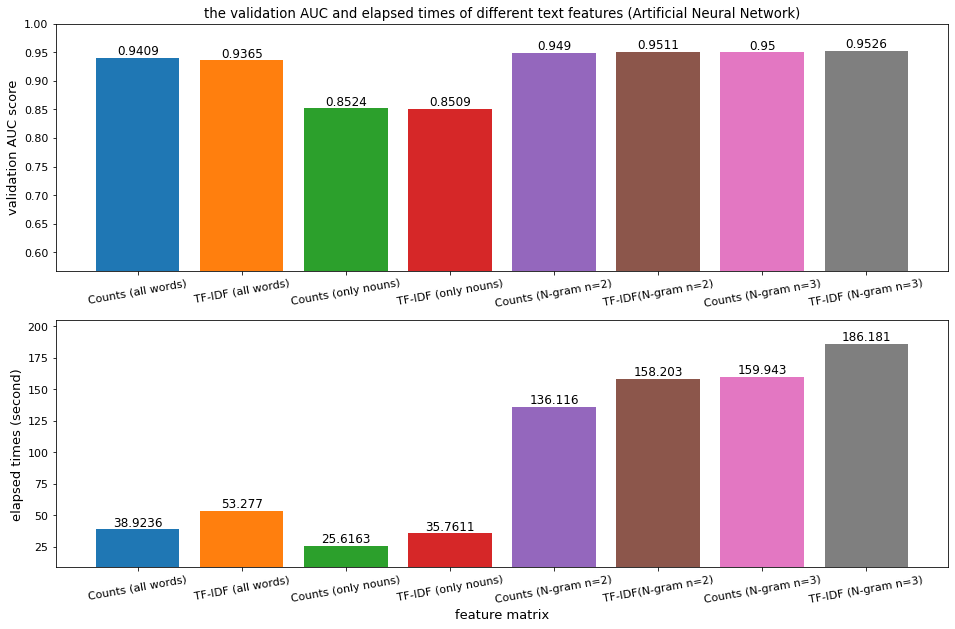

In [27]:
from sklearn.metrics import roc_auc_score
import time as t

# plot the auc score and elapsed times  of different text features
def plot_auc_elapsed_feature(labels, y1, y2, title):
    x  = np.linspace(1,len(labels),len(labels))
    y1 = np.round(y1,4)
    y2 = np.round(y2,4)

    plt.figure(figsize=(16,9)) 
    fig,ax = plt.subplots(2,1,figsize=(16,10))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    ax[0].set_title("the validation AUC and elapsed times of different text features " + title)
    ax[0].set_ylabel("validation AUC score",fontsize=13)
    ax[0].set_ylim(np.min(y1)/1.5, np.max(y1)*1.05)
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels, rotation=10)
    bar0 = ax[0].bar(x, y1, color=colors)
    ax[0].bar_label(bar0,fontsize=12)

    ax[1].set_xlabel("feature matrix",fontsize=13)
    ax[1].set_ylabel("elapsed times (second)",fontsize=13)
    ax[1].set_ylim(np.min(y2)/3, np.max(y2)*1.1)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels, rotation=10)
    bar1 = ax[1].bar(x, y2 ,color=colors)
    ax[1].bar_label(bar1,fontsize=12)
    
# create  ANN Model
def model_ann(x_train,y_train,x_test,y_test,batch_size,epochs):
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    # train model
    ann_model = create_ann()
    ann_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    # return auc score
    return roc_auc_score(y_test, ann_model.predict(x_test))

auc_ann = []
elapsed_ann = []
# Count tokenizer (all words)
start_time = t.time()
auc_ann.append(model_ann(X_train_count,y_train_count,X_test_count,y_test_count,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# TF-IDF features (all words)
start_time = t.time()
auc_ann.append(model_ann(X_train_tfidf,y_train_tfidf,X_test_tfidf,y_test_tfidf,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# token counts (only nouns)
start_time = t.time()
auc_ann.append(model_ann(X_train_nouns_count,y_train_nouns_count,X_test_nouns_count,y_test_nouns_count,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# TF-IDF features (only nouns)
start_time = t.time()
auc_ann.append(model_ann(X_train_nouns_tfidf,y_train_nouns_tfidf,X_test_nouns_tfidf,y_test_nouns_tfidf,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# token counts (N-gram n=2)
start_time = t.time()
auc_ann.append(model_ann(X_train_ngram2_count,y_train_ngram2_count,X_test_ngram2_count,y_test_ngram2_count,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# TF-IDF features (N-gram n=2)
start_time = t.time()
auc_ann.append(model_ann(X_train_ngram2_tfidf,y_train_ngram2_tfidf,X_test_ngram2_tfidf,y_test_ngram2_tfidf,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# token counts (N-gram n=3)
start_time = t.time()
auc_ann.append(model_ann(X_train_ngram3_count,y_train_ngram3_count,X_test_ngram3_count,y_test_ngram3_count,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# TF-IDF features (N-gram n=3)
start_time = t.time()
auc_ann.append(model_ann(X_train_ngram3_tfidf,y_train_ngram3_tfidf,X_test_ngram3_tfidf,y_test_ngram3_tfidf,best_batch_size,best_epochs))
elapsed_ann.append(t.time()-start_time)

# plot the auc score and elapsed times  of different text features
plot_auc_elapsed_feature(feature,auc_ann,elapsed_ann,'(Artificial Neural Network)')

#### 2.3. Remove words that appear less frequently and compare the auc scores of different frequencies  

<Figure size 1440x720 with 0 Axes>

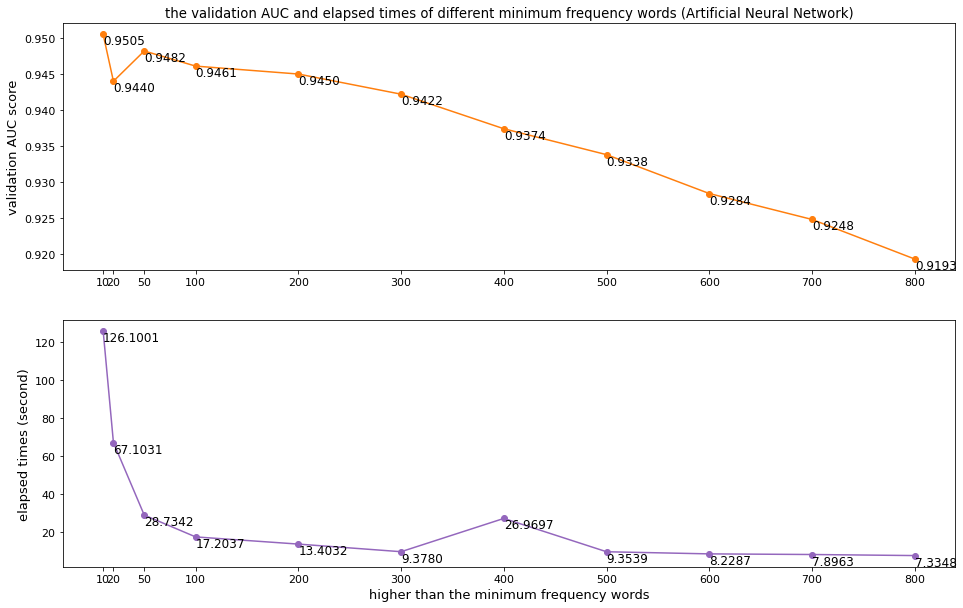

In [28]:
# plot the auc score and elapsed times of different minimum frequency words
def plot_auc_elapsed_frequency(labels, y1, y2, title):
    x = labels
    y1 = np.round(y1,4)
    y2 = np.round(y2,4)
    
    plt.figure(figsize=(20,10)) 
    fig,ax = plt.subplots(2,1,figsize=(16,10))

    # colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    ax[0].set_title("the validation AUC and elapsed times of different minimum frequency words " + title)
    ax[0].set_ylabel("validation AUC score",fontsize=13)
    ax[0].set_xticks(x)
    # ax[0].grid(visible=True)
    ax[0].plot(x,y1,'o-',color='#ff7f0e')
    
    for a,b in zip(x, y1):
        ax[0].text(a, b, '%.4f' % b, ha='left', va= 'top',fontsize=12)

    ax[1].set_xlabel("higher than the minimum frequency words",fontsize=13)
    ax[1].set_ylabel("elapsed times (second)",fontsize=13)
    ax[1].set_xticks(x)
    # ax[1].grid(visible=True)
    ax[1].plot(x, y2,'o-',color='#9467bd')
    for a,b in zip(x, y2):
        ax[1].text(a, b, '%.4f' % b, ha='left', va= 'top',fontsize=12)

# higher than the minimum frequency words
number_list = [10,20,50,100,200,300,400,500,600,700,800]

num = []
auc_ann1 = []
elapsed_ann1 = []
for i in number_list:
    # select the top i most frequent words
    tf_word_list = np.array(ngram3_freq['word'][ngram3_freq['freq']>=i])

    # a matrix of token counts as training and test data set
    x_train = X_train_ngram3_tfidf[tf_word_list]
    y_train = y_train_ngram3_tfidf
    x_test = X_test_ngram3_tfidf[tf_word_list]
    y_test = y_test_ngram3_tfidf
    
    start_time = t.time()
    # evaluate model
    num.append(i)
    auc_ann1.append(model_ann(x_train,y_train,x_test,y_test,best_batch_size,best_epochs))
    elapsed_ann1.append(t.time()-start_time)
    
plot_auc_elapsed_frequency(number_list,auc_ann1,elapsed_ann1,'(Artificial Neural Network)')

#### 2.4. Generate the model with the best parameters, predict and generate classification report, confusion matrix.

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3972
           1       0.91      0.91      0.91      5628

    accuracy                           0.89      9600
   macro avg       0.89      0.89      0.89      9600
weighted avg       0.89      0.89      0.89      9600



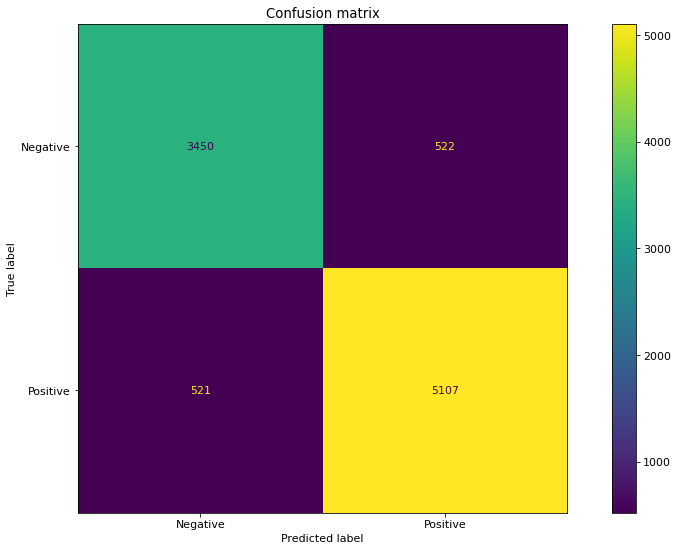

In [36]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# print classification reports and Confusion Matrix visualization
def print_report_matrix(y_pred, y_test):
    #print classification reports
    print('Classification report:')
    print(classification_report(y_test,y_pred))

    # Confusion Matrix visualization
    cm = confusion_matrix(y_test,y_pred)
    labels = ['Negative','Positive']
    disp = ConfusionMatrixDisplay(cm,display_labels = labels)
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()    
    
tf_word_list = np.array(ngram3_freq['word'][ngram3_freq['freq']>=1])
# a matrix of token counts as training and test data set
x_train = np.array(X_train_ngram3_count[tf_word_list])
y_train = np.array(y_train_ngram3_count)
x_test = np.array(X_test_ngram3_count[tf_word_list])
y_test = np.array(y_test_ngram3_count)
    
# train model
ann_model = create_ann()
ann_model.fit(x_train, y_train, batch_size=best_batch_size, epochs=best_epochs, verbose=0)

# classification reports and Confusion Matrix visualization
y_pred = ann_model.predict(x_test)
y_pred = (y_pred+0.5).astype(int)
print_report_matrix(y_pred, y_test)

# save model AUC score and accuracy
model_attr.append(['Artificial Neural Network',roc_auc_score(y_test,ann_model.predict(x_test)),accuracy_score(y_test,y_pred)])

#### 2.5. Save the entire model and the top most frequent words.

In [40]:
# Save the entire model to a HDF5 file.
ann_model.save('Sentiment_analysis_for_Amazon_Review.h5')

# save the top most frequent words
tf_word_list = np.array(ngram3_freq['word'][ngram3_freq['freq']>=1])
df_tf_word = pd.DataFrame(tf_word_list,columns=['top_frequent_words'])
df_tf_word.to_csv('top_most_frequent_words.csv')

#### 2.6 Reload the model and test it with some sentence.

In [41]:
# Recreate the model
new_ann_model = tf.keras.models.load_model('Sentiment_analysis_for_Amazon_Review.h5')
new_ann_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 32)                1009344   
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 16)                528       
                                                                 
 dropout_49 (Dropout)        (None, 16)                0         
                                                                 
 dense_74 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,009,889
Trainable params: 1,009,889
Non-trainable params: 0
_________________________________________________________________


In [42]:
# load the top most frequent words
tf_word_list = pd.read_csv('top_most_frequent_words.csv')[
    'top_frequent_words'].to_list()

# vectorize sequences
def vectorize_sequences(sequences, tf_word_list: list):
    # Create an all-zero matrix of shape (len(sequences), len(tf_word_list))
    results = np.zeros((len(sequences), len(tf_word_list)))

    for i, sequence in enumerate(sequences):
        # Process the given sequence, removing HTML tags, stop words, Perform  lemmatize.
        sequence = process_text(sequence, lemmatize=True, only_nouns=False)
        words = sequence.split(' ')
        for word in words:
            if word in tf_word_list:
                results[i][tf_word_list.index(word)] += 1
    return results

# test it with some sentence.
sequences = ["This  is great stuff.  Made some really tasty banana bread.  Good quality and lowest price in town.",
            "i have bought allot of different flavors and this happens to be one of my favorites and will be getting more soon",
            "Terrible! Artificial lemon taste, like Pledge Lemon Furniture Polish. Don't do this to yourself. ",
            "Just awful!  I thought food was supposed to taste good!  I had to eat ice cream afterwards to get the taste out of my mouth."
            ]

text_vector = vectorize_sequences(sequences, tf_word_list)
text_vector.shape
pred_results = new_ann_model.predict(text_vector)

# test results
df_results = pd.DataFrame(sequences,columns=['sequences'])
df_results['score'] = pred_results
df_results['review'] = df_results['score'].apply(lambda x : 'Negative' if x < 0.5 else 'Positive')
df_results

,sequences,score,review
0,This is great stuff. Made some really tasty ...,9.994715e-01,Positive
1,i have bought allot of different flavors and t...,6.931062e-01,Positive
2,"Terrible! Artificial lemon taste, like Pledge ...",1.562513e-06,Negative
3,Just awful! I thought food was supposed to ta...,9.594708e-07,Negative


### 3.Multinomial Naive Bayes Classifier Model 

 #### 3.1. Create Multinomial Naive Bayes Classifier Model，Compare the auc score of different feature matrix.

<Figure size 1152x648 with 0 Axes>

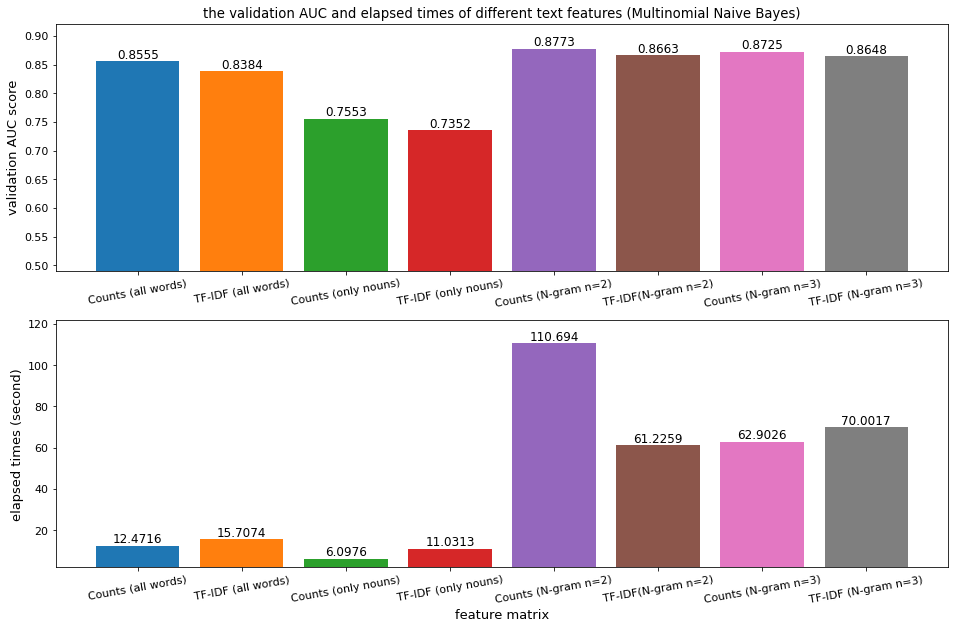

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import time as t

# create  Multinomial Naive Bayes Classifier Model
def model_mnb(x_train,y_train,x_test,y_test):
    # train model
    clf = MultinomialNB()
    clf.fit(x_train,y_train)
    # return auc score
    return roc_auc_score(y_test, clf.predict(x_test))


auc_mnb = []
elapsed_mnb = []
# Count tokenizer (all words)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_count,y_train_count,X_test_count,y_test_count))
elapsed_mnb.append(t.time()-start_time)

# TF-IDF features (all words)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_tfidf,y_train_tfidf,X_test_tfidf,y_test_tfidf))
elapsed_mnb.append(t.time()-start_time)

# token counts (only nouns)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_nouns_count,y_train_nouns_count,X_test_nouns_count,y_test_nouns_count))
elapsed_mnb.append(t.time()-start_time)

# TF-IDF features (only nouns)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_nouns_tfidf,y_train_nouns_tfidf,X_test_nouns_tfidf,y_test_nouns_tfidf))
elapsed_mnb.append(t.time()-start_time)

# token counts (N-gram n=2)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_ngram2_count,y_train_ngram2_count,X_test_ngram2_count,y_test_ngram2_count))
elapsed_mnb.append(t.time()-start_time)

# TF-IDF features (N-gram n=2)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_ngram2_tfidf,y_train_ngram2_tfidf,X_test_ngram2_tfidf,y_test_ngram2_tfidf))
elapsed_mnb.append(t.time()-start_time)

# token counts (N-gram n=3)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_ngram3_count,y_train_ngram3_count,X_test_ngram3_count,y_test_ngram3_count))
elapsed_mnb.append(t.time()-start_time)

# TF-IDF features (N-gram n=3)
start_time = t.time()
auc_mnb.append(model_mnb(X_train_ngram3_tfidf,y_train_ngram3_tfidf,X_test_ngram3_tfidf,y_test_ngram3_tfidf))
elapsed_mnb.append(t.time()-start_time)

# plot the auc score and elapsed times  of different text features
plot_auc_elapsed_feature(feature,auc_mnb,elapsed_mnb,'(Multinomial Naive Bayes)')

#### 3.2. Remove words that appear less frequently and compare the auc scores of different frequencies.

<Figure size 1440x720 with 0 Axes>

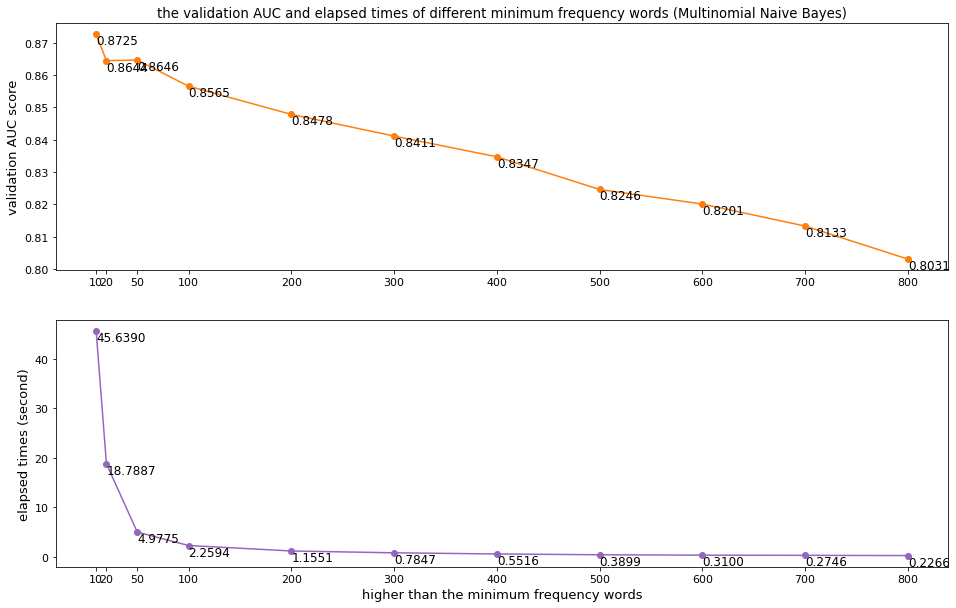

In [44]:
# higher than the minimum frequency words
number_list = [10,20,50,100,200,300,400,500,600,700,800]

num = []
auc_mnb1 = []
elapsed_mnb1 = []
for i in number_list:
    # select the top i most frequent words
    tf_word_list = np.array(ngram3_freq['word'][ngram3_freq['freq']>=i])

    # a matrix of token counts as training and test data set
    x_train = np.array(X_train_ngram3_count[tf_word_list])
    y_train = np.array(y_train_ngram3_count)
    x_test = np.array(X_test_ngram3_count[tf_word_list])
    y_test = np.array(y_test_ngram3_count)
    
    start_time = t.time()
    # evaluate model
    num.append(i)
    auc_mnb1.append(model_mnb(x_train,y_train,x_test,y_test))
    elapsed_mnb1.append(t.time()-start_time)
    
plot_auc_elapsed_frequency(number_list,auc_mnb1,elapsed_mnb1,'(Multinomial Naive Bayes)')

#### 3.3. generate classification report, confusion matrix.

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3972
           1       0.88      0.93      0.90      5628

    accuracy                           0.88      9600
   macro avg       0.89      0.87      0.88      9600
weighted avg       0.88      0.88      0.88      9600



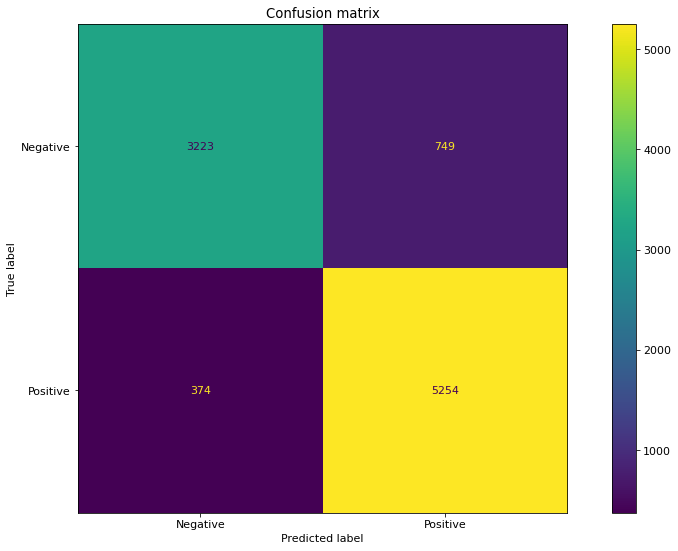

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# print classification reports and Confusion Matrix visualization
def print_report_matrix(y_pred, y_test):
    #print classification reports
    print('Classification report:')
    print(classification_report(y_test,y_pred))

    # Confusion Matrix visualization
    cm = confusion_matrix(y_test,y_pred)
    labels = ['Negative','Positive']
    disp = ConfusionMatrixDisplay(cm,display_labels = labels)
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()    
    

# train model
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_ngram3_count,y_train_ngram3_count)

# classification reports and Confusion Matrix visualization
print_report_matrix(clf_mnb.predict(X_test_ngram3_count), y_test_ngram3_count)

y_test = y_test_ngram3_count
y_pred = clf_mnb.predict(X_test_ngram3_count)
# save model AUC score and accuracy
model_attr.append(['Multinomial Naive Bayes',roc_auc_score(y_test,y_pred),accuracy_score(y_test,y_pred)])

### 4. Logistic Regression Model 

 4.1. Create Logistic Regression Model， Compare the auc score of different feature matrix.

<Figure size 1152x648 with 0 Axes>

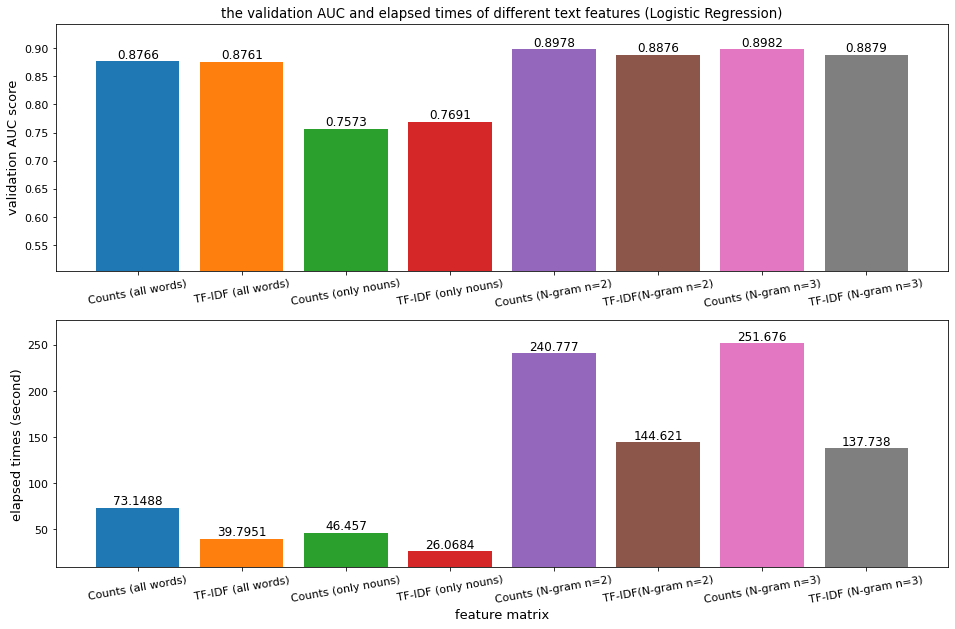

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def model_lr(x_train,y_train,x_test,y_test):
    # train model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train,y_train)
    # return auc score
    return roc_auc_score(y_test, clf.predict(x_test))

auc_lr = []
elapsed_lr = []

# Count tokenizer (all words)
start_time = t.time()
auc_lr.append(model_lr(X_train_count,y_train_count,X_test_count,y_test_count))
elapsed_lr.append(t.time()-start_time)

# TF-IDF features (all words)
start_time = t.time()
auc_lr.append(model_lr(X_train_tfidf,y_train_tfidf,X_test_tfidf,y_test_tfidf))
elapsed_lr.append(t.time()-start_time)

# token counts (only nouns)
start_time = t.time()
auc_lr.append(model_lr(X_train_nouns_count,y_train_nouns_count,X_test_nouns_count,y_test_nouns_count))
elapsed_lr.append(t.time()-start_time)

# TF-IDF features (only nouns)
start_time = t.time()
auc_lr.append(model_lr(X_train_nouns_tfidf,y_train_nouns_tfidf,X_test_nouns_tfidf,y_test_nouns_tfidf))
elapsed_lr.append(t.time()-start_time)

# token counts (N-gram n=2)
start_time = t.time()
auc_lr.append(model_lr(X_train_ngram2_count,y_train_ngram2_count,X_test_ngram2_count,y_test_ngram2_count))
elapsed_lr.append(t.time()-start_time)

# TF-IDF features (N-gram n=2)
start_time = t.time()
auc_lr.append(model_lr(X_train_ngram2_tfidf,y_train_ngram2_tfidf,X_test_ngram2_tfidf,y_test_ngram2_tfidf))
elapsed_lr.append(t.time()-start_time)

# token counts (N-gram n=3)
start_time = t.time()
auc_lr.append(model_lr(X_train_ngram3_count,y_train_ngram3_count,X_test_ngram3_count,y_test_ngram3_count))
elapsed_lr.append(t.time()-start_time)

# TF-IDF features (N-gram n=3)
start_time = t.time()
auc_lr.append(model_lr(X_train_ngram3_tfidf,y_train_ngram3_tfidf,X_test_ngram3_tfidf,y_test_ngram3_tfidf))
elapsed_lr.append(t.time()-start_time)

plot_auc_elapsed_feature(feature,auc_lr,elapsed_lr,'(Logistic Regression)')


#### 4.2. Remove words that appear less frequently and compare the auc scores of different frequencies.

<Figure size 1440x720 with 0 Axes>

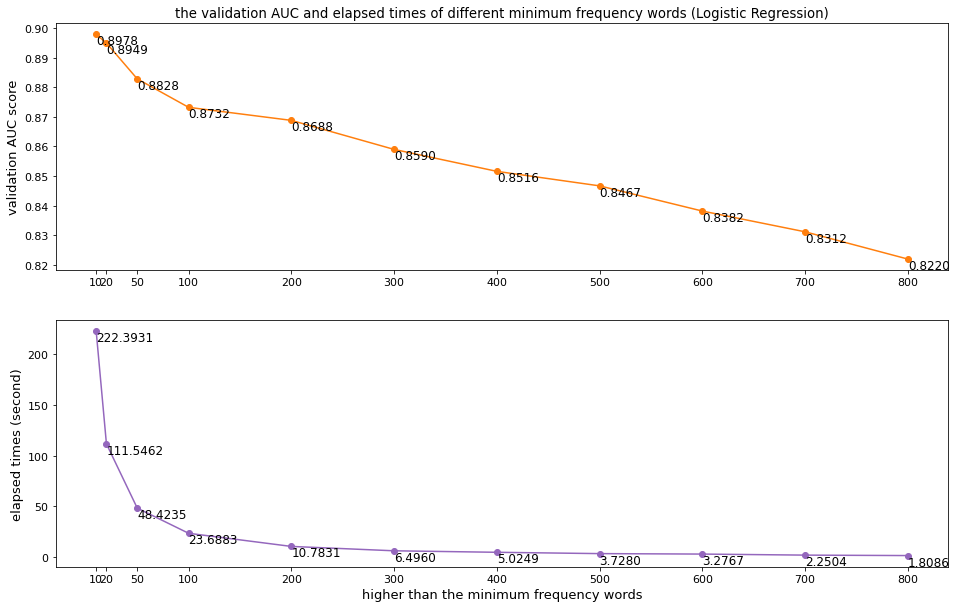

In [47]:
number_list = [10,20,50,100,200,300,400,500,600,700,800]

num = []
auc_lr1 = []
elapsed_lr1 = []
for i in number_list:

    # a matrix of token counts as training and test data set
    tf_word_list = np.array(ngram2_freq['word'][ngram2_freq['freq']>=i])
    # select the top i most frequent words
    x_train = np.array(X_train_ngram2_count[tf_word_list])
    y_train = np.array(y_train_ngram2_count)
    x_test = np.array(X_test_ngram2_count[tf_word_list])
    y_test = np.array(y_test_ngram2_count)    
    
    # evaluate model
    start_time = t.time()
    num.append(i)
    auc_lr1.append(model_lr(x_train,y_train,x_test,y_test))
    elapsed_lr1.append(t.time()-start_time)

# plot the AUC and elapsed time of different minimum frequency of words    
plot_auc_elapsed_frequency(number_list,auc_lr1,elapsed_lr1,'(Logistic Regression)')

#### 4.3 generate classification report, confusion matrix.

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3972
           1       0.91      0.92      0.92      5628

    accuracy                           0.90      9600
   macro avg       0.90      0.90      0.90      9600
weighted avg       0.90      0.90      0.90      9600



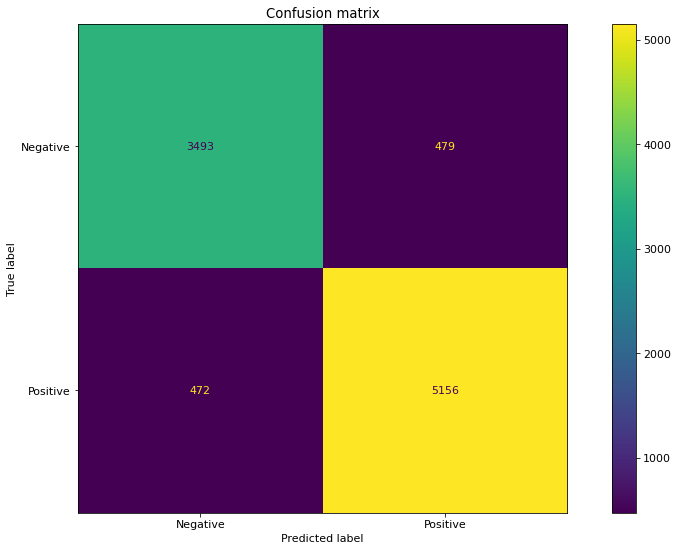

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# print classification reports and Confusion Matrix visualization
def print_report_matrix(y_pred, y_test):
    #print classification reports
    print('Classification report:')
    print(classification_report(y_test,y_pred))

    # Confusion Matrix visualization
    cm = confusion_matrix(y_test,y_pred)
    labels = ['Negative','Positive']
    disp = ConfusionMatrixDisplay(cm,display_labels = labels)
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()    


tf_word_list = np.array(ngram2_freq['word'][ngram2_freq['freq']>=10])
# select the top i most frequent words
x_train = np.array(X_train_ngram2_count[tf_word_list])
y_train = np.array(y_train_ngram2_count)
x_test = np.array(X_test_ngram2_count[tf_word_list])
y_test = np.array(y_test_ngram2_count)    

# train model
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(x_train,y_train)

# classification reports and Confusion Matrix visualization
print_report_matrix(clf_lr.predict(x_test), y_test)

y_pred = clf_lr.predict(x_test)
# save model AUC score and accuracy
model_attr.append(['Logistic Regression',roc_auc_score(y_test,y_pred),accuracy_score(y_test,y_pred)])

del x_train,y_train,x_test,y_test

### 5. Bidirectional Encoder Representations from Transformers (BERT) model.

In [49]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import tensorflow as tf
# import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re
import sklearn.model_selection as ms
from keras import models
import tokenization
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [50]:
bert_data = df_sample[['Text']]
# Calculate and record the length of text for each row
bert_data['len'] = bert_data.Text.apply(lambda x: len(x.split()))

#  Drop rows that has too words in "text"
bert_data = bert_data[bert_data.len<50]

#Remove html tags
bert_data['Text']=bert_data['Text'].apply(lambda row : re.sub('<.*?>','',row))

bert_data['Score']=df_sample['Score']

In [51]:
# Split the data
# df_data = bert_data.sample(n=5000,random_state=30)
df_data = bert_data

X_data = df_data[['Text','len']]
y_data = df_data[['Score']]

X_train, X_test, y_train, y_test = ms.train_test_split(X_data,y_data, test_size=0.2, stratify=y_data)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

del df_data,X_data,y_data

In [52]:
# Check the shape
print("Shape of X_train and X_test:")
print(X_train.shape,X_test.shape)
print("Shape of y_train and y_test:")
print(y_train.shape,y_test.shape)

Shape of X_train and X_test:
(16181, 2) (4046, 2)
Shape of y_train and y_test:
(16181, 2) (4046, 2)


In [53]:
# Build the bert input
max_seq_length = 55
# tf.keras.backend.clear_session()

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

In [54]:
# Import the bert
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [55]:
# Load the tokenizer
print("Loading tokenizer...")
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer =tokenization.FullTokenizer(vocab_file,do_lower_case)

Loading tokenizer...


In [56]:
# Process the data into the bert input
def bert_preprocess(sentence, tokenizer, max_seq_len=512):
    tokens = []
    masks = []
    segments = []
    for word in sentence:
        word = tokenizer.tokenize(word)
        word = word[:max_seq_len - 2]
        seq = ["[CLS]"] + word + ["[SEP]"]
        # print(seq)
        token = tokenizer.convert_tokens_to_ids(seq)
        # print(token)
        padding_tokens = token + [0] * (max_seq_len - len(token)) 
        mask = [1] * len(seq)
        masking = mask + [0] * (max_seq_len - len(token))
        segment = np.zeros(max_seq_length)

        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens), np.array(masks), np.array(segments)

print("Preprocessing bert input...")
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,55)

Preprocessing bert input...


In [57]:
# Get the bert output
print("Calculating BERT output...")
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

Calculating BERT output...


In [58]:
# Set the callback for the AUC calculating
auc = []
val_auc = []
class AUC_CallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        auc_train = (roc_auc_score(y_train, (self.model.predict(X_train_pooled_output))))
        auc_test = (roc_auc_score(y_test, (self.model.predict(X_test_pooled_output))))
        print(' - train auc: {0:.4f} - test auc: {1:.4f}'.format(auc_train, auc_test))
        auc.append(auc_train)
        val_auc.append(auc_test)

myCallback = AUC_CallBack()

In [59]:
# Build the supervised learning model by Keras
model = models.Sequential()
model.add(Dense(400, activation='relu',input_shape=(768,)))
model.add(Dense(220, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

tf.keras.backend.clear_session()

In [60]:
# Train the model
his=model.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[myCallback])

Epoch 1/50
506/506 [==============================] - 3s 6ms/step - loss: 0.4784 - accuracy: 0.7655 - val_loss: 0.3466 - val_accuracy: 0.8468
Epoch 2/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3602 - accuracy: 0.8415 - val_loss: 0.3219 - val_accuracy: 0.8631
Epoch 3/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3339 - accuracy: 0.8583 - val_loss: 0.3698 - val_accuracy: 0.8235
Epoch 4/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3224 - accuracy: 0.8614 - val_loss: 0.3068 - val_accuracy: 0.8693
Epoch 5/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3293 - accuracy: 0.8582 - val_loss: 0.3404 - val_accuracy: 0.8445
Epoch 6/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3118 - accuracy: 0.8699 - val_loss: 0.3011 - val_accuracy: 0.8764
Epoch 7/50
506/506 [==============================] - 3s 5ms/step - loss: 0.3060 - accuracy: 0.8739 - val_loss: 0.3164 - val_accuracy: 0.8670
Epoch 

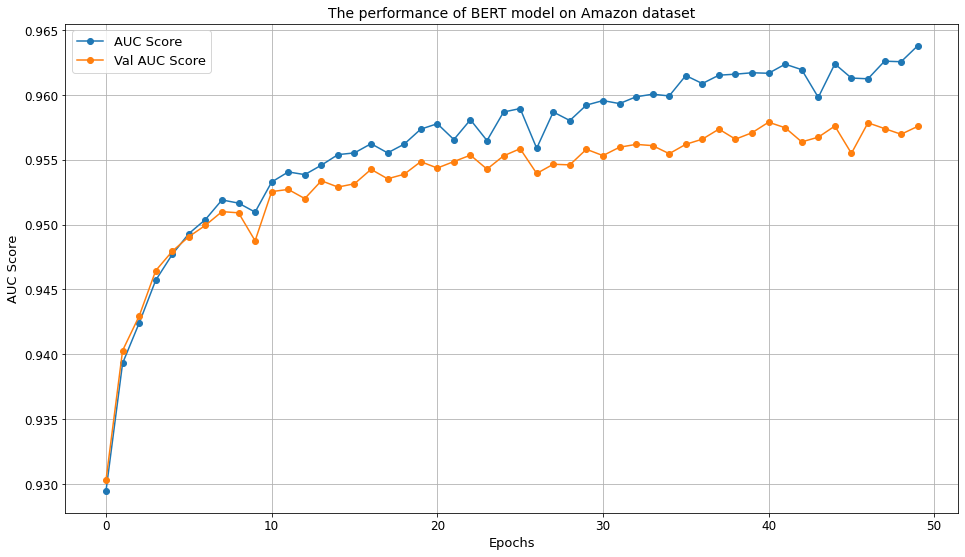

In [61]:
# Plot the picture
plt.figure(figsize=(16,9))
plt.plot(np.arange(len(auc)),auc,'o-',label='AUC Score')
plt.plot(np.arange(len(auc)),val_auc,'o-',label='Val AUC Score')
plt.xlabel('Epochs',fontsize=13)
plt.ylabel('AUC Score',fontsize=13)
plt.legend(fontsize=13)
plt.title("The performance of BERT model on Amazon dataset",fontsize=14)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86      1489
           1       0.90      0.94      0.92      2557

    accuracy                           0.90      4046
   macro avg       0.90      0.88      0.89      4046
weighted avg       0.90      0.90      0.90      4046



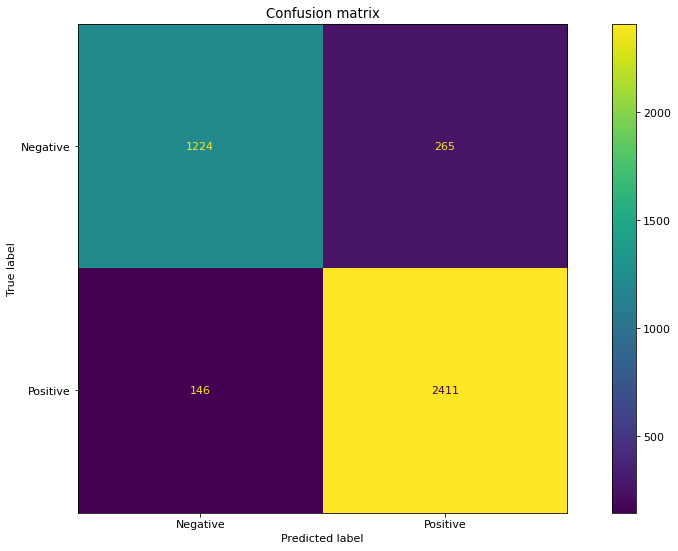

In [62]:
# Make the classification report, and confusion matrix
y_pred = model.predict(X_test_pooled_output)
y_p=np.argmax(y_pred,axis=1)
y_t=np.argmax(y_test,axis=1)

# classification reports and Confusion Matrix visualization
print_report_matrix(y_p, y_t)

# save model AUC score and accuracy
model_attr.append(['BERT model',np.max(val_auc),accuracy_score(y_t,y_p)])


In [63]:
# Apply some experiment on this model
example=["This is great stuff. Made some really tasty banana bread. Good quality and lowest price in town.",
"This oatmeal is good. Its mushy, soft, I like it. Quaker Oats is the way to go.",
"Terrible! Artificial lemon taste, like Pledge Lemon Furniture Polish. Don't do this to yourself. ",
"Just awful! I thought food was supposed to taste good! I had to eat ice cream afterwards to get the taste out of my mind"
]

print("Calculating example sentence...")
E_test_tokens, E_test_mask, E_test_segment=bert_preprocess(example,tokenizer,55)
E_test_pooled_output=bert_model.predict([E_test_tokens,E_test_mask,E_test_segment])
example_pred=model.predict(E_test_pooled_output)
print("Their possibility distribution is:",example_pred)
example_pred=np.argmax(example_pred,axis=1)
print("Their predicted classification is:",example_pred)

Calculating example sentence...
Their possibility distribution is: [[0.01863441 0.98183745]
 [0.0102655  0.9900367 ]
 [0.9894744  0.0099276 ]
 [0.9375968  0.05964929]]
Their predicted classification is: [1 1 0 0]


### 6.Performance Comparison

#### 6.1 the AUC score of different models base on feature matrix.

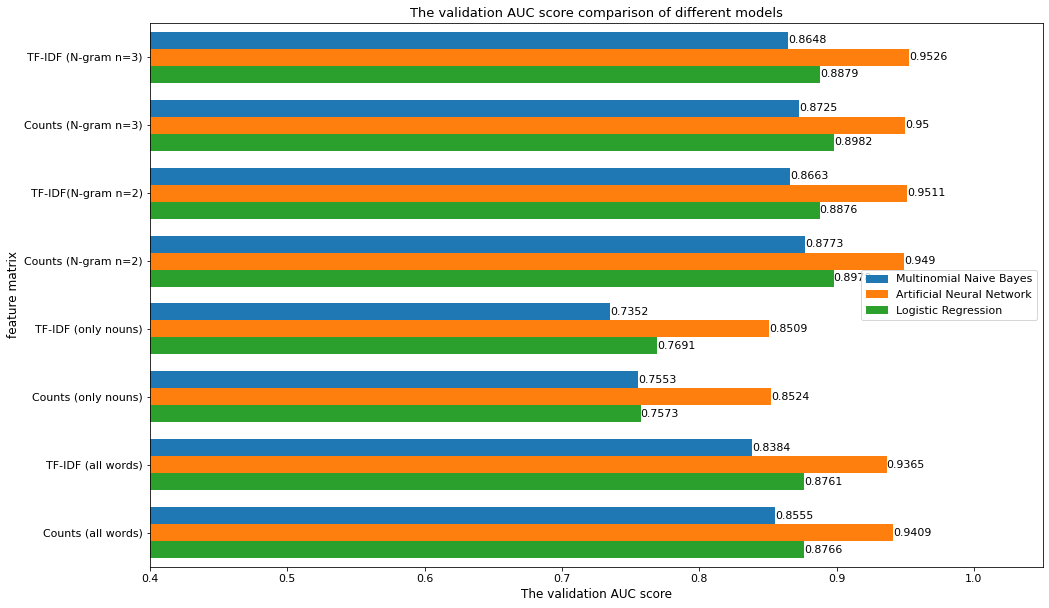

In [64]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

y = np.linspace(1,len(feature),len(feature))
plt.figure(figsize=(16,10))
plt.ylim(0.5,8.5)
plt.xlim(0.4,1.05)
width = 0.25
bar1 = plt.barh(y+width, np.round(auc_mnb,4), width, label='Multinomial Naive Bayes', color=colors[0] )
plt.bar_label(bar1)
bar2 = plt.barh(y,       np.round(auc_ann,4), width, label='Artificial Neural Network', color=colors[1], tick_label=feature)
plt.bar_label(bar2)
bar3 = plt.barh(y-width, np.round(auc_lr, 4), width, label='Logistic Regression', color=colors[2])
plt.bar_label(bar3)
plt.ylabel('feature matrix',fontsize=12)
plt.xlabel('The validation AUC score',fontsize=12)
plt.title('The validation AUC score comparison of different models',fontsize=13)
plt.legend() 
plt.show()

#### 6.2 the elapsed times of different models.

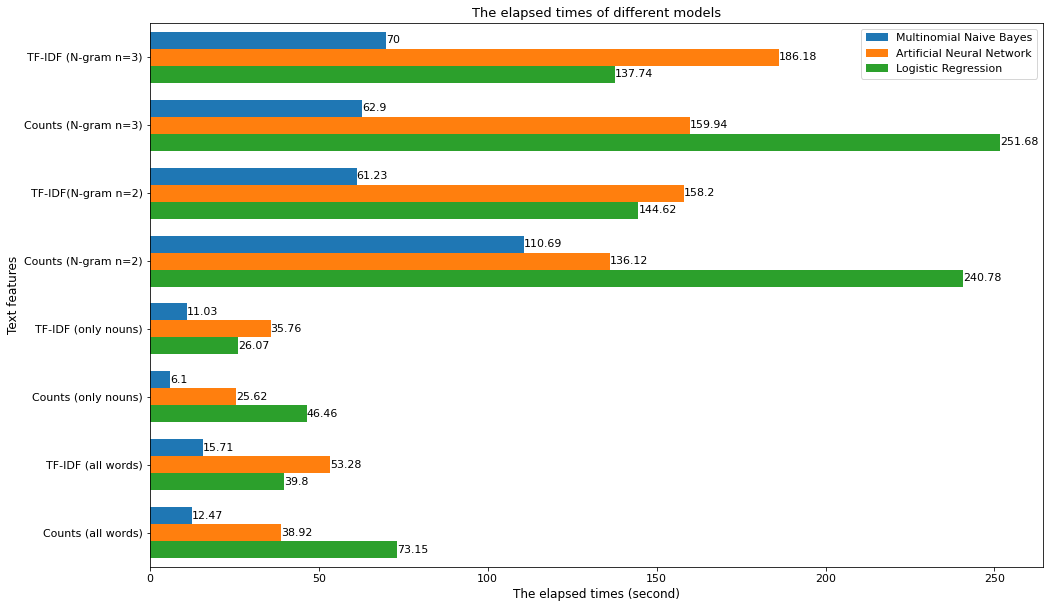

In [65]:

y = np.linspace(1,len(feature),len(feature))
plt.figure(figsize=(16,10))
plt.ylim(0.5,8.5)
width = 0.25

bar1 = plt.barh(y+width, np.round(elapsed_mnb,2), width, label='Multinomial Naive Bayes', color=colors[0] )
plt.bar_label(bar1)
bar2 = plt.barh(y,       np.round(elapsed_ann,2), width, label='Artificial Neural Network', color=colors[1], tick_label=feature)
plt.bar_label(bar2)
bar3 = plt.barh(y-width, np.round(elapsed_lr, 2), width, label='Logistic Regression', color=colors[2])
plt.bar_label(bar3)
plt.ylabel('Text features',fontsize=12)
plt.xlabel('The elapsed times (second)',fontsize=12)
plt.title('The elapsed times of different models',fontsize=13)
plt.legend()
plt.show()

#### 6.3 The auc score and accuracy of different models

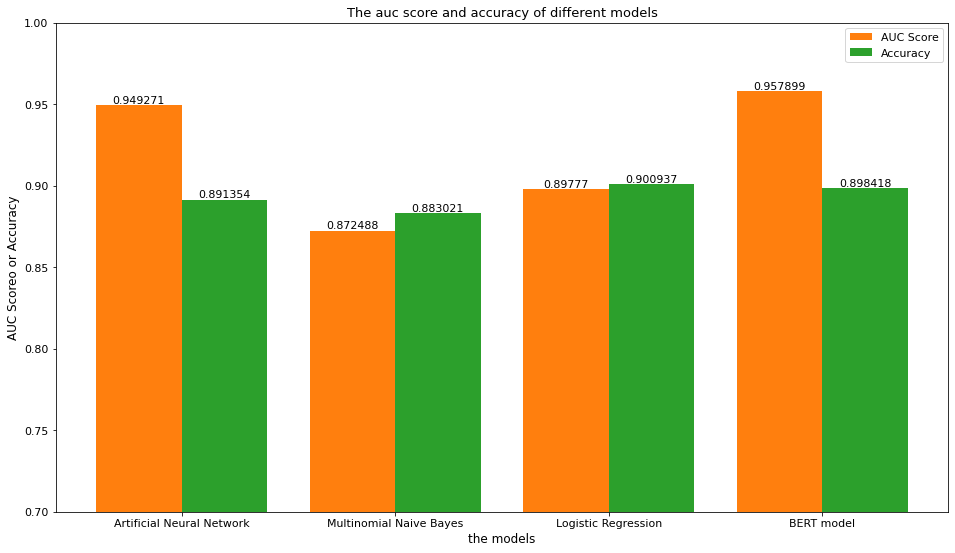

In [66]:
df_model = pd.DataFrame(model_attr)
x = np.linspace(1,len(model_attr),len(model_attr))
plt.figure(figsize=(16,9))
plt.ylim(0.7,1.0)
width = 0.4

bar1 = plt.bar(x-width/2, df_model[1], width, label='AUC Score', color=colors[1] )
plt.bar_label(bar1)
bar2 = plt.bar(x, df_model[2], 0, tick_label=df_model[0])

bar3 = plt.bar(x+width/2, df_model[2], width, label='Accuracy', color=colors[2])
plt.bar_label(bar3)
plt.ylabel('AUC Scoreo or Accuracy',fontsize=12)
plt.xlabel('the models',fontsize=12)
plt.title('The auc score and accuracy of different models',fontsize=13)
plt.legend()
plt.show()